# Response time minimization - Inland police district

### Version 4.0

- Goal: Minimize the response time of police vehicles in Oslo police district, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


#### Innlandet police district
Innlandet police district covers all 46 municipalities in Innlandet county. The police district is the country's largest in terms of extent. The district has approximately 900 employees and serves approximately 370,000 residents. The population density is greatest around Mjøsa. The headquarters of the police district is in Hamar.

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-16T23:21:10.212306+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium
import utilityModule # own custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

shapely   : 2.0.3
osmnx     : 1.9.1
pandana   : 0.7
folium    : 0.16.0
geopandas : 0.14.3
pulp      : 2.8.0
pandas    : 2.2.1
matplotlib: 3.8.3
networkx  : 3.2.1
highspy   : 1.5.3
pyproj    : 3.6.1
numpy     : 1.26.4



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Edges contain road speeds and travel times. Node centrality has been computed and saved locally.

In [3]:
### Load road network from file
Inland_filepath = "../data/Inland/InlandDriveImputed.graphml" # with travel time attribute
Inland_graph = ox.load_graphml(Inland_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
Inland_graph = ox.projection.project_graph(Inland_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of Inland_graph: {type(Inland_graph)}")
print(f"CRS of Inland_graph:  {Inland_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(Inland_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of Inland_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Inland_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Inland_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid ref        name highway maxspeed  oneway  \
u      v          key                                                       
157219 5377956142 0    404598775   2  Arko-vegen   trunk       50   False   
       5377956148 0    520928793   2  Arko-vegen   trunk       50   False   

                      reversed  length  speed_kph  travel_time  \
u      v          key                                            
157219 5377956142 0       True  12.511     50.000        0.900   
       5377956148 0      False  34.169     50.000        2.500   

                                                                geometry  \
u      v          key                                                      
157219 5377956142 0    LINESTRING (345140.259 6647317.407, 345150.998...   
       5377956148 0    LINESTRING (345140.259 6647317.407, 345110.601...   

                      lanes junction bridge tunnel access width service  \
u      v          key                                                     
157219 5377956142 0     NaN      NaN    NaN    NaN    NaN   NaN     NaN   
       5377956148 0     NaN      NaN    NaN    NaN    NaN   NaN     NaN   

                      est_width  
u      v          key            
157219 5377956142 0         NaN  
       5377956148 0         NaN

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [6]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Inland_polygon_path = "../data/Inland/InlandCombinedPolygon.geojson"
Inland_polygon_gdf = gpd.read_file(Inland_polygon_path)
Inland_polygon_gdf = Inland_polygon_gdf.to_crs(Inland_graph.graph['crs']) # convert to same CRS as the road network

In [7]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Inland/InlandPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Inland_graph.graph['crs']) # convert to same CRS as the road network

In [8]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  21145006897750           2   
1  21150006897500           4   

                                            geometry  
0  MULTIPOLYGON (((114750.002 6897749.998, 114500...  
1  MULTIPOLYGON (((115250.002 6897499.998, 115000...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [9]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1000, max_range=1100) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1520, max_range=1560) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 7):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1538. Target range [1520, 1560], using population multiplier: 0.008347656250000002
Nr of cells with 0 events: 33915
Nr of cells with 1 events: 1284
Nr of cells with 2 events: 100
Nr of cells with 3 events: 13
Nr of cells with 4 events: 2
Nr of cells with 5 events: 0
Nr of cells with 6 events: 0


id  population  \
20776  22857506746250         848   
15562  22652506748000         431   
20492  22842506747500         466   

                                                geometry  num_points  
20776  MULTIPOLYGON (((286000.000 6746250.000, 285750...           7  
15562  MULTIPOLYGON (((265500.000 6748000.000, 265250...           4  
20492  MULTIPOLYGON (((284500.000 6747500.000, 284250...           4

In [10]:
%%time
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 1.28 s
Wall time: 2.19 s


geometry
0  POINT (146334.766 6879157.872)
1  POINT (146644.698 6879156.661)
2  POINT (153907.919 6793688.828)

In [11]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=5.0e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 6.560e-60 | Median: 7.637e-13 | Mean: 1.633e-11 | Max: 4.229e-10


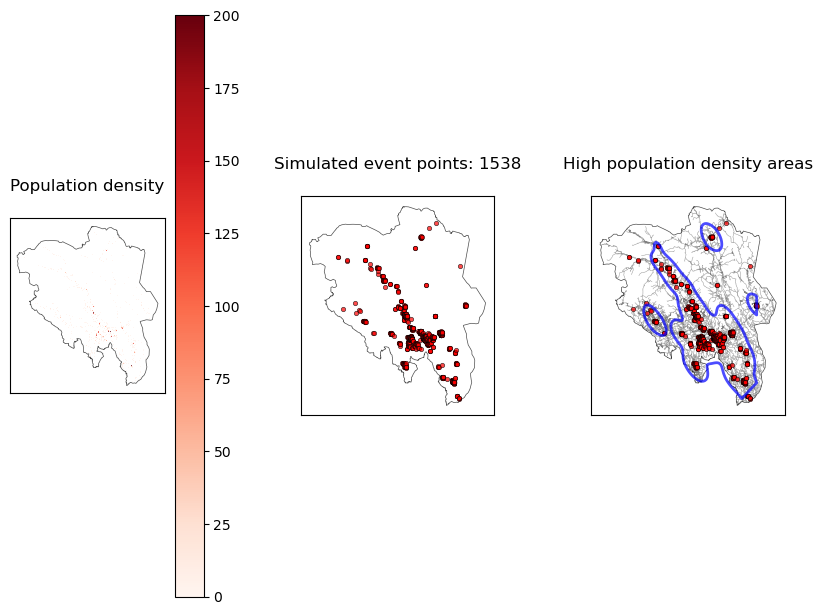

In [12]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Inland_polygon_gdf, population_gdf, event_points_gdf, 
                                                                                high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [13]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/Inland/InlandNodeCentrality.csv")

# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  ref  \
osmid                                                                        
157219     6647317.407 345140.259             3 12.229 59.934     NaN  NaN   
5377956142 6647310.914 345150.998             3 12.229 59.934     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
157219      POINT (345140.259 6647317.407)                 0.000   
5377956142  POINT (345150.998 6647310.914)                 0.000   

            betweenness_centrality  
osmid                               
157219                  413321.000  
5377956142              338189.000

### 2.2 Sample candidate points and filter out best candidate points

In [14]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 37587, nr of police car nodes: 100


y          x  street_count    lon    lat highway  ref  \
osmid                                                                        
3718759939 6900502.081 281885.977             3 10.810 62.173     NaN  NaN   
8401629499 6747067.490 284341.262             1 11.036 60.800     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
3718759939  POINT (281885.977 6900502.081)                 0.000   
8401629499  POINT (284341.262 6747067.490)                 0.000   

            betweenness_centrality  
osmid                               
3718759939              902992.000  
8401629499                   0.000

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


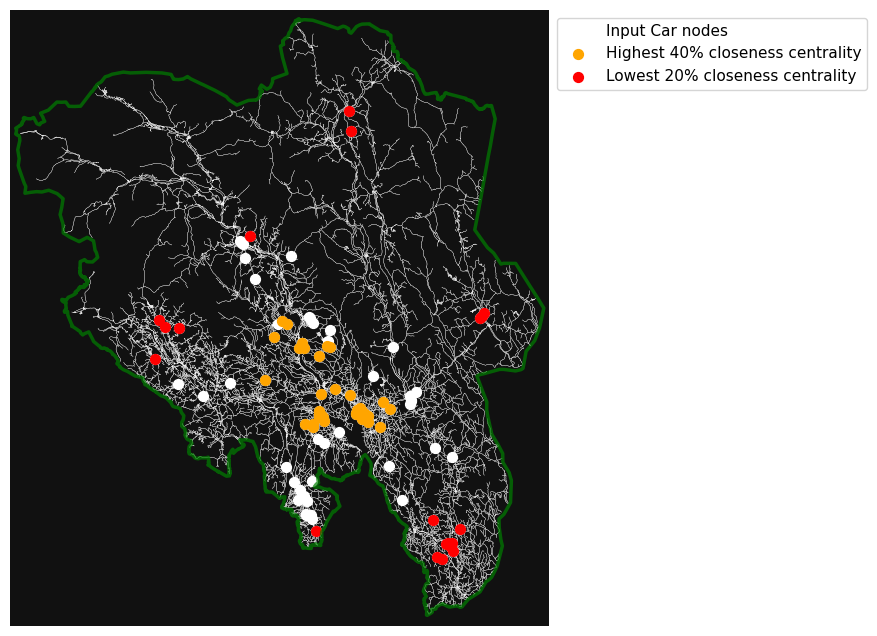

In [15]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Inland_polygon_gdf, 
            top_percent=0.4, bottom_percent=0.20, input_graph=Inland_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 48, after discarding the 32 (40%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


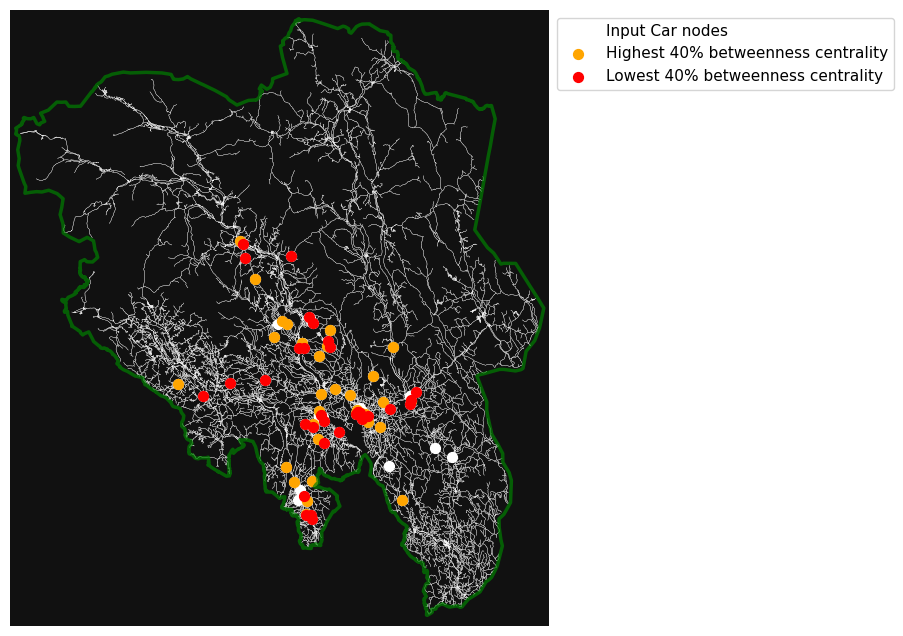

In [16]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Inland_polygon_gdf, 
                top_percent=0.4, bottom_percent=0.40, input_graph=Inland_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 48
Remaining nr of car nodes: 21, after removing the 27 nodes that are within 10000 m of each other



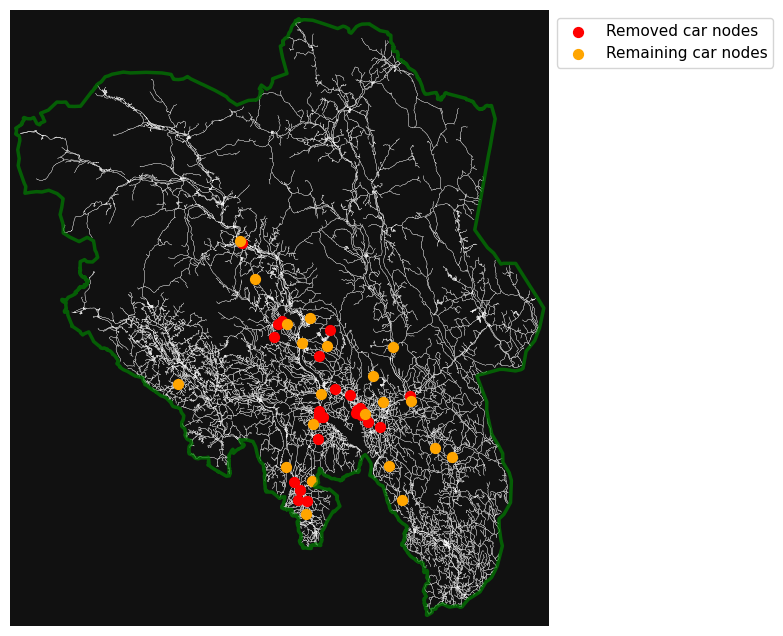

In [17]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Inland_polygon_gdf, 
                min_distance=10000, input_graph=Inland_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [18]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
Inland_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Inland_network_pdna: {type(Inland_network_pdna)}")
print(f"Network nodes:")
Inland_network_pdna.nodes_df.head(2)

type of Inland_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                            
157219     345140.259 6647317.407
5377956142 345150.998 6647310.914

In [19]:
print(f"Network edges: ")
Inland_network_pdna.edges_df.head(2)

Network edges: 


from          to  length  travel_time
0  157219  5377956142  12.511        0.900
1  157219  5377956148  34.169        2.500

In [21]:
# %%time
# Inland_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [22]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Inland_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node          x           y
0  POINT (146334.766 6879157.872)    5458900280 146330.803 6879168.404
1  POINT (146644.698 6879156.661)    5458901442 146710.771 6879134.776

In [23]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Inland_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
print("Length of event_nodes_pdna: ", len(event_nodes_pdna))
print("Number of unique nodes: ", len(np.unique(event_nodes_pdna)))
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Inland_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

Length of event_nodes_pdna:  1538
Number of unique nodes:  1461


array([2747959098, 4604721617, 7872901488,  850245317, 7872899900],
      dtype=int64)

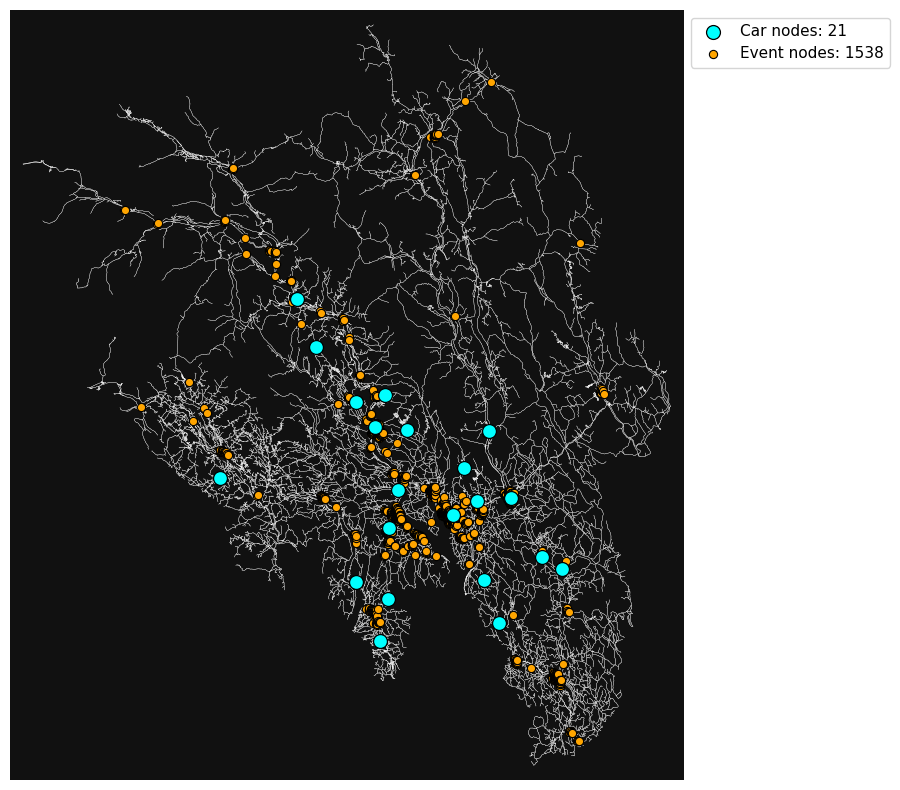

In [24]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Inland_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [25]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [26]:
%%time
# travel time between each possible pair of car-event combination
distances = Inland_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Inland_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

21 origins x 1538 destinations = 32298 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [212676.684, 212331.723, 149169.011, 196270.034, 196151.137]
5 first origin-destination travel times [sec]: [10472.097, 10437.297, 7532.599, 9547.597, 9535.497]
CPU times: total: 1.11 s
Wall time: 164 ms


In [27]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count   mean    std   min    25%    50%    75%     max
0 32298.000 69.937 39.872 0.102 42.317 63.323 92.257 260.193

In [28]:
# Restructure the distances and travel times arrays into a DataFrame (CInland Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID          x           y
0 212676.684    10472.097  2747959098   5458900280 146330.803 6879168.404
1 212331.723    10437.297  2747959098   5458901442 146710.771 6879134.776

In [29]:
# Save cInland matrix to CSV
CostMatrix.to_csv("../data/Inland/InlandCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [30]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time   carNodeID   eventNodeID
0    10472.097  2747959098  5458900280_1
1    10437.297  2747959098  5458901442_1

In [32]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
margin = len(event_nodes_pdna) * 0.015
CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)

# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 407 events per car
Filtering out 0% highest travel times - keeping only travel times <= 15612 sec, or 260.2 min
Original nr of pairs: 32298 | Filtered nr of pairs: 32298
Original max travel time: 15611.598 | Filtered max travel time: 15611.598


### 5.2 Setup LP problem

In [33]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 21
Number of events: 1538
Number of decision variables: 32319
Number of constraints: 33858
Number of non-zero coefficients: 32319
Number of non-zero coefficients in the objective function: 32298
CPU times: total: 1.25 s
Wall time: 2.17 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).


In [34]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 3/4 locations in 6.79 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 37.57 seconds: [4604721617 7836537247 5937100961 7886088959]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 2191044.2780 seconds, or 36517.40 minutes, or 608.62 hours
CPU times: total: 3.33 s
Wall time: 47.8 s


### 5.6 Extract results for inspection

In [35]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
# print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/oslo/osloCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Car 4604721617 is assigned 407/407 events
Car 7836537247 is assigned 407/407 events
Car 5937100961 is assigned 346/407 events
Car 7886088959 is assigned 378/407 events
Summing the events for each car gives 1538 events, which should equal the total number of unique events: 1538


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 21 | Optimal locations in solution: 4
- Events: 1538 | Max event capacity per police car: 407

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 2191044 sec | 36517.4 min | 608.62 hours

Car id: 4604721617 handles 407 events | Capacity: 100.00% | Total response time: 2547.16 min | Median: 5.49 min | Avg: 6.26 min
Car id: 7836537247 handles 407 events | Capacity: 100.00% | Total response time: 7678.30 min | Median: 9.04 min | Avg: 18.87 min
Car id: 5937100961 handles 346 events | Capacity: 85.01% | Total response time: 11052.98 min | Median: 8.43 min | Avg: 31.95 min
Car id: 7886088959 handles 378 events | Capacity: 92.87% | Total response time: 15238.96 min | Median: 28.70 min | Avg: 40.31 min


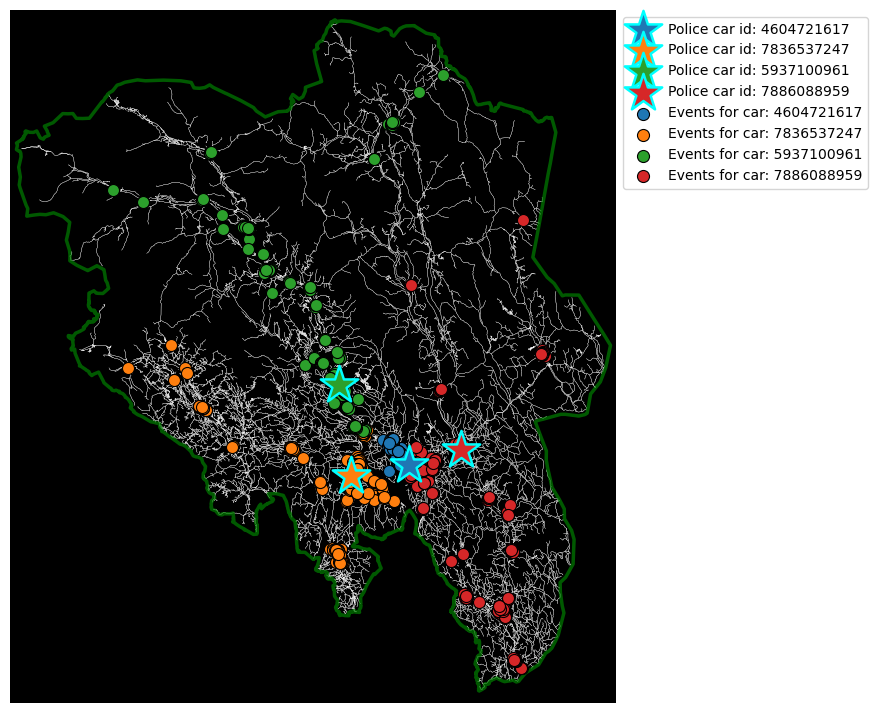

CPU times: total: 5.61 s
Wall time: 8.68 s


In [38]:
%%time
utilityModule.plot_optimal_allocations(Inland_graph, Inland_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(9,9))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [37]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 150]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

Isochrone polygons for the travel times: [20, 60, 150] minutes


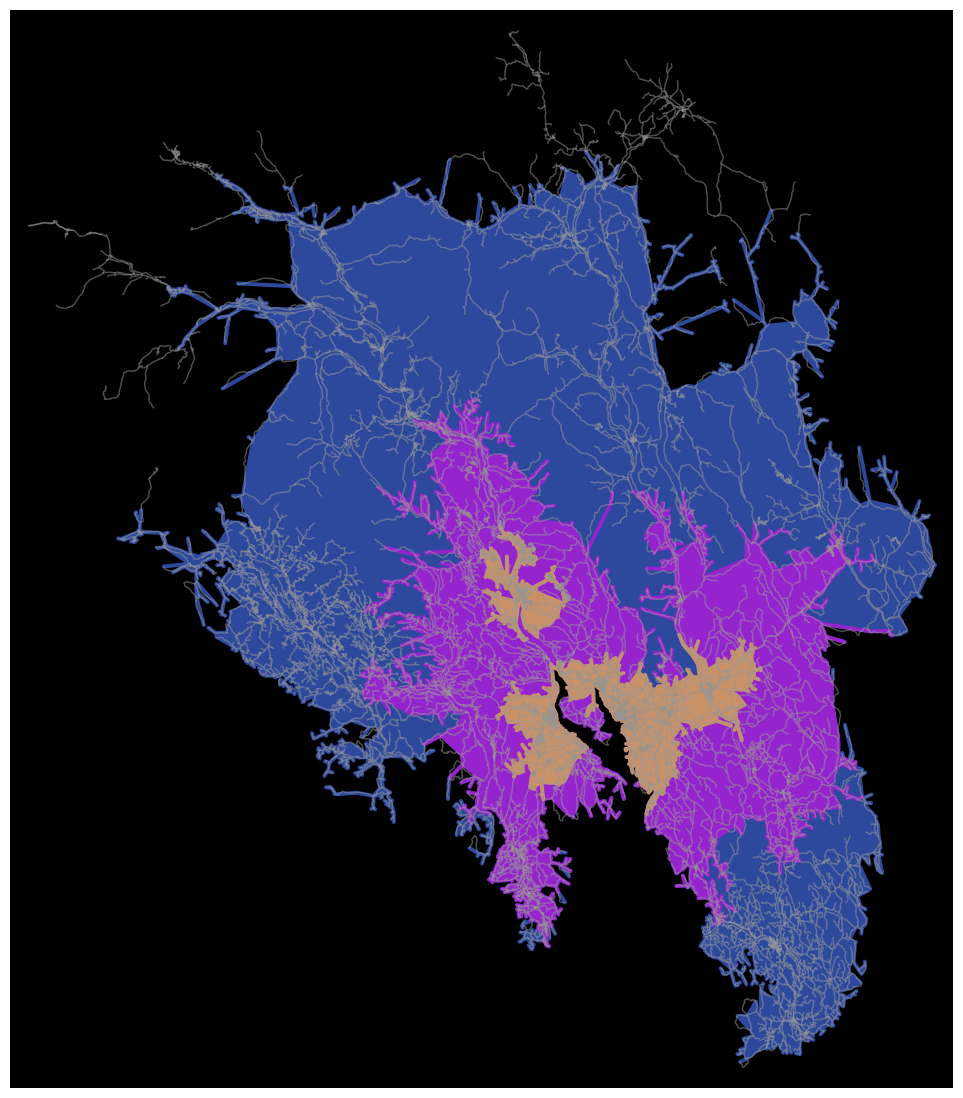

CPU times: total: 2min 22s
Wall time: 3min 31s


In [40]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Inland_graph, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=600, node_buff=0, infill=True)

# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(Inland_graph, isochrone_polys)

# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Inland_graph, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(14, 14))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

In [55]:
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(Inland_graph, TRIP_TIMES, merged_isochrones, Inland_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 891 ms
Wall time: 1.46 s
